In [1]:
# =========================================
# 0) Warning Management (UYARI TEMİZLEME)
# =========================================
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# =========================================
# 1) Kütüphaneler
# =========================================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import RFE
from sklearn.decomposition import TruncatedSVD

# =========================================
# 2) Veri Yükleme
# =========================================
file_path = "/Users/revahauctepe/Desktop/SonHali_Kategorili_Liste.xlsx"
df = pd.read_excel(file_path)

print("Data shape:", df.shape)
display(df.head())

print("\nMissing values per column:")
print(df.isna().sum())

print("\nDuplicated rows:", df.duplicated().sum())

print("\nTarget distribution (LC_Kategori):")
print(df["LC_Kategori"].value_counts())

# =========================================
# 3) Features ve Target
# =========================================
target_col = "LC_Kategori"

if "ÖğrenciKimlik-no" in df.columns:
    df_model = df.drop(columns=["ÖğrenciKimlik-no"])
else:
    df_model = df.copy()

X = df_model.drop(columns=[target_col])
y = df_model[target_col]

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("\nNumeric features:", numeric_features)
print("Categorical features:", categorical_features)

# =========================================
# 4) Train / Test Split
# =========================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# =========================================
# 5) Preprocessing (OneHot + Scaling)
# =========================================
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(with_mean=False), numeric_features),
    ]
)

X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)

print("\nEncoded X_train shape:", X_train_enc.shape)

# =========================================
# 6) Model Değerlendirme Fonksiyonu (TAM)
# =========================================
def eval_model(stage, name, model, X_tr, y_tr, X_te, y_te, results_list):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_te, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_te, y_pred, average="macro", zero_division=0)

    print(f"\n=== {stage} | {name} ===")
    print(f"Accuracy        : {acc:.4f}")
    print(f"Precision (mac) : {prec:.4f}")
    print(f"Recall (mac)    : {rec:.4f}")
    print(f"F1-score (mac)  : {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_te, y_pred, zero_division=0))

    results_list.append({
        "Stage": stage,
        "Model": name,
        "Accuracy": acc,
        "Precision_macro": prec,
        "Recall_macro": rec,
        "F1_macro": f1
    })

# =========================================
# 7) Modeller
# =========================================
logreg = LogisticRegression(
    max_iter=2000,
    solver="lbfgs",
    multi_class="multinomial",
    n_jobs=-1
)

knn = KNeighborsClassifier(n_neighbors=7)

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

results = []

# =========================================
# 8) Stage 1: Original Features
# =========================================
stage1 = "Original Features"

for model_name, model in [
    ("LogisticRegression", logreg),
    ("RandomForest", rf)
]:
    eval_model(
        stage1, model_name, model,
        X_train_enc, y_train,
        X_test_enc, y_test,
        results
    )

# =========================================
# 9) Stage 2: Feature Selection (RFE)
# =========================================
stage2 = "After Feature Selection (RFE, 40 features)"

rfe_selector = RFE(
    estimator=LogisticRegression(
        max_iter=2000,
        solver="lbfgs",
        multi_class="multinomial"
    ),
    n_features_to_select=40,
    step=0.1
)

X_train_fs = rfe_selector.fit_transform(X_train_enc, y_train)
X_test_fs = rfe_selector.transform(X_test_enc)

print("\nAfter RFE shapes:", X_train_fs.shape, X_test_fs.shape)

for model_name, model in [
    ("LogisticRegression", logreg),
    ("RandomForest", rf)
]:
    eval_model(
        stage2, model_name, model,
        X_train_fs, y_train,
        X_test_fs, y_test,
        results
    )

# =========================================
# 10) Stage 3: Dimension Reduction (SVD)
# =========================================
stage3 = "After Dimension Reduction (TruncatedSVD, n=20)"

svd = TruncatedSVD(n_components=20, random_state=42)

X_train_dr = svd.fit_transform(X_train_enc)
X_test_dr = svd.transform(X_test_enc)

print("\nAfter DR shapes:", X_train_dr.shape, X_test_dr.shape)

for model_name, model in [
    ("LogisticRegression", logreg),
    ("KNN (k=7)", knn),
    ("RandomForest", rf)
]:
    eval_model(
        stage3, model_name, model,
        X_train_dr, y_train,
        X_test_dr, y_test,
        results
    )

# =========================================
# 11) Summary Table (TAM AKADEMİK)
# =========================================
results_df = pd.DataFrame(results)

results_df = results_df.sort_values(
    by=["F1_macro", "Recall_macro", "Precision_macro", "Accuracy"],
    ascending=False
).reset_index(drop=True)

print("\n===== Summary Table (Accuracy, Precision, Recall, F1) =====")
display(results_df)


Data shape: (13436, 6)


,ÖğrenciKimlik-no,Cinsiyet,Fakülte,Bölüm,Kitap-ID,LC_Kategori
0,509005326,Kadın,Turizm Fakültesi,Gastronomi ve Mutfak Sanatları,GY151,Diğerleri
1,421475486,Kadın,Mühendislik ve Doğa Bilimleri Fakültesi,Biyomühendislik,B3004,Bilim
2,660301107,Erkek,Sağlık Bilimleri Fakültesi,Odyoloji,Tip4081,Tıp
3,534575034,Kadın,Edebiyat Fakültesi,Sosyoloji Bölümü,DE2527,Dil ve Edebiyat
4,331718324,Kadın,Hukuk Fakültesi,Hukuk Bölümü,H9821,Hukuk



Missing values per column:
ÖğrenciKimlik-no    0
Cinsiyet            0
Fakülte             0
Bölüm               0
Kitap-ID            0
LC_Kategori         0
dtype: int64

Duplicated rows: 0

Target distribution (LC_Kategori):
LC_Kategori
Dil ve Edebiyat            3274
Tıp                        2703
Hukuk                      1016
Siyaset Bilimi             1001
Felsefe, Psikoloji, Din     965
Bilim                       957
Güzel Sanatlar              952
Eğitim                      913
Sosyal Bilimler             904
Diğerleri                   751
Name: count, dtype: int64

Numeric features: []
Categorical features: ['Cinsiyet', 'Fakülte', 'Bölüm', 'Kitap-ID']

Encoded X_train shape: (10748, 9797)

=== Original Features | LogisticRegression ===
Accuracy        : 0.7347
Precision (mac) : 0.6633
Recall (mac)    : 0.7765
F1-score (mac)  : 0.6938

Classification Report:
                         precision    recall  f1-score   support

                  Bilim       0.70      0.92    

,Stage,Model,Accuracy,Precision_macro,Recall_macro,F1_macro
0,Original Features,RandomForest,0.735491,0.763789,0.777355,0.695510
1,Original Features,LogisticRegression,0.734747,0.663349,0.776536,0.693761
2,"After Feature Selection (RFE, 40 features)",LogisticRegression,0.734747,0.663349,0.776536,0.693761
3,"After Feature Selection (RFE, 40 features)",RandomForest,0.734747,0.663349,0.776536,0.693761
4,"After Dimension Reduction (TruncatedSVD, n=20)",LogisticRegression,0.734747,0.663349,0.776536,0.693761
5,"After Dimension Reduction (TruncatedSVD, n=20)",RandomForest,0.683408,0.644714,0.693657,0.658588
6,"After Dimension Reduction (TruncatedSVD, n=20)",KNN (k=7),0.652530,0.628429,0.673408,0.643206


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score
)


In [3]:
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader

# ================================
# Label Encoding (PyTorch için)
# ================================
label_encoder = LabelEncoder()

y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc  = label_encoder.transform(y_test)

# ================================
# Torch tensor formatına çevir
# ================================
X_train_torch = torch.tensor(X_train_enc.toarray(), dtype=torch.float32)
X_test_torch  = torch.tensor(X_test_enc.toarray(), dtype=torch.float32)

y_train_torch = torch.tensor(y_train_enc, dtype=torch.long)
y_test_torch  = torch.tensor(y_test_enc, dtype=torch.long)

# ================================
# Dataset & DataLoader
# ================================
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset  = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ================================
# Model parametreleri
# ================================
input_dim = X_train_torch.shape[1]
num_classes = len(label_encoder.classes_)

print("Input dim:", input_dim)
print("Num classes:", num_classes)


Input dim: 9797
Num classes: 10


In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [5]:
class DeepMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(DeepMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [6]:
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for Xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(Xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")


In [7]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for Xb, yb in test_loader:
            outputs = model(Xb)
            probs = torch.softmax(outputs, dim=1)

            y_true.extend(yb.numpy())
            y_pred.extend(torch.argmax(outputs, dim=1).numpy())
            y_prob.extend(probs.numpy())

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    auc = roc_auc_score(y_true, y_prob, multi_class="ovr")

    return acc, prec, rec, f1, auc


In [8]:
mlp_model = MLP(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

train_model(mlp_model, train_loader, criterion, optimizer, epochs=20)

mlp_results = evaluate_model(mlp_model, test_loader)
print("MLP Results (Acc, Prec, Recall, F1, AUC):", mlp_results)


Epoch 1/20 - Loss: 217.3583
Epoch 2/20 - Loss: 133.4300
Epoch 3/20 - Loss: 112.9436
Epoch 4/20 - Loss: 88.5178
Epoch 5/20 - Loss: 63.6589
Epoch 6/20 - Loss: 41.6262
Epoch 7/20 - Loss: 24.6714
Epoch 8/20 - Loss: 13.8886
Epoch 9/20 - Loss: 8.0810
Epoch 10/20 - Loss: 4.9191
Epoch 11/20 - Loss: 3.4387
Epoch 12/20 - Loss: 2.4226
Epoch 13/20 - Loss: 1.8797
Epoch 14/20 - Loss: 1.4505
Epoch 15/20 - Loss: 1.1415
Epoch 16/20 - Loss: 0.9282
Epoch 17/20 - Loss: 0.7759
Epoch 18/20 - Loss: 0.6564
Epoch 19/20 - Loss: 0.5447
Epoch 20/20 - Loss: 0.4697
MLP Results (Acc, Prec, Recall, F1, AUC): (0.7596726190476191, 0.7826436715464251, 0.8011447190393681, 0.7388791093217522, 0.9135002452920847)


In [9]:
deep_mlp_model = DeepMLP(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(deep_mlp_model.parameters(), lr=0.001)

train_model(deep_mlp_model, train_loader, criterion, optimizer, epochs=25)

deep_mlp_results = evaluate_model(deep_mlp_model, test_loader)
print("Deep MLP Results (Acc, Prec, Recall, F1, AUC):", deep_mlp_results)


Epoch 1/25 - Loss: 161.8643
Epoch 2/25 - Loss: 103.6127
Epoch 3/25 - Loss: 33.3648
Epoch 4/25 - Loss: 8.7222
Epoch 5/25 - Loss: 4.2816
Epoch 6/25 - Loss: 2.8170
Epoch 7/25 - Loss: 2.0218
Epoch 8/25 - Loss: 2.3697
Epoch 9/25 - Loss: 1.7688
Epoch 10/25 - Loss: 1.7351
Epoch 11/25 - Loss: 2.4151
Epoch 12/25 - Loss: 2.9570
Epoch 13/25 - Loss: 3.4595
Epoch 14/25 - Loss: 5.6046
Epoch 15/25 - Loss: 6.6860
Epoch 16/25 - Loss: 5.4378
Epoch 17/25 - Loss: 4.8250
Epoch 18/25 - Loss: 3.3764
Epoch 19/25 - Loss: 2.3792
Epoch 20/25 - Loss: 1.5061
Epoch 21/25 - Loss: 1.5517
Epoch 22/25 - Loss: 1.2229
Epoch 23/25 - Loss: 1.1404
Epoch 24/25 - Loss: 0.6537
Epoch 25/25 - Loss: 0.5273
Deep MLP Results (Acc, Prec, Recall, F1, AUC): (0.7451636904761905, 0.7714087275535707, 0.7880067992842508, 0.7176282249878231, 0.9004214320214434)


In [10]:
results.append({
    "Stage": "Final - PyTorch",
    "Model": "MLP",
    "Accuracy": mlp_results[0],
    "Precision_macro": mlp_results[1],
    "Recall_macro": mlp_results[2],
    "F1_macro": mlp_results[3]
})

results.append({
    "Stage": "Final - PyTorch",
    "Model": "Deep MLP",
    "Accuracy": deep_mlp_results[0],
    "Precision_macro": deep_mlp_results[1],
    "Recall_macro": deep_mlp_results[2],
    "F1_macro": deep_mlp_results[3]
})

results_df = pd.DataFrame(results)
display(results_df)


,Stage,Model,Accuracy,Precision_macro,Recall_macro,F1_macro
0,Original Features,LogisticRegression,0.734747,0.663349,0.776536,0.693761
1,Original Features,RandomForest,0.735491,0.763789,0.777355,0.695510
2,"After Feature Selection (RFE, 40 features)",LogisticRegression,0.734747,0.663349,0.776536,0.693761
3,"After Feature Selection (RFE, 40 features)",RandomForest,0.734747,0.663349,0.776536,0.693761
4,"After Dimension Reduction (TruncatedSVD, n=20)",LogisticRegression,0.734747,0.663349,0.776536,0.693761
5,"After Dimension Reduction (TruncatedSVD, n=20)",KNN (k=7),0.652530,0.628429,0.673408,0.643206
6,"After Dimension Reduction (TruncatedSVD, n=20)",RandomForest,0.683408,0.644714,0.693657,0.658588
7,Final - PyTorch,MLP,0.759673,0.782644,0.801145,0.738879
8,Final - PyTorch,Deep MLP,0.745164,0.771409,0.788007,0.717628


In [11]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


In [12]:
def plot_multiclass_roc(model, test_loader, n_classes, title):
    model.eval()
    y_true = []
    y_score = []

    with torch.no_grad():
        for Xb, yb in test_loader:
            outputs = model(Xb)
            probs = torch.softmax(outputs, dim=1)

            y_true.extend(yb.numpy())
            y_score.extend(probs.numpy())

    y_true = np.array(y_true)
    y_score = np.array(y_score)

    # One-vs-Rest için binarize
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    plt.figure(figsize=(7, 6))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


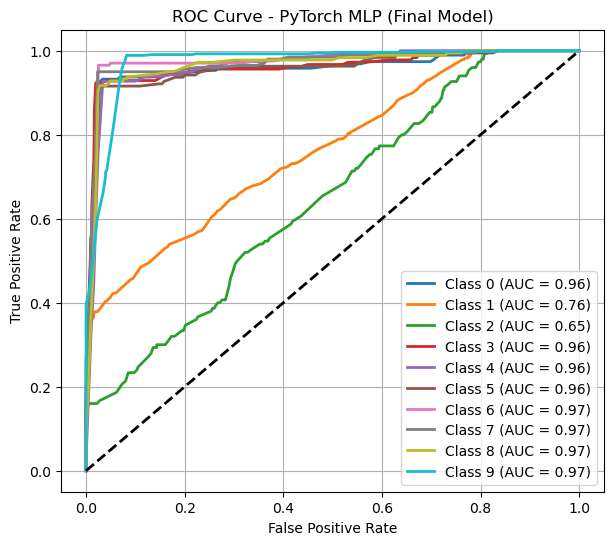

In [13]:
plot_multiclass_roc(
    model=mlp_model,
    test_loader=test_loader,
    n_classes=num_classes,
    title="ROC Curve - PyTorch MLP (Final Model)"
)


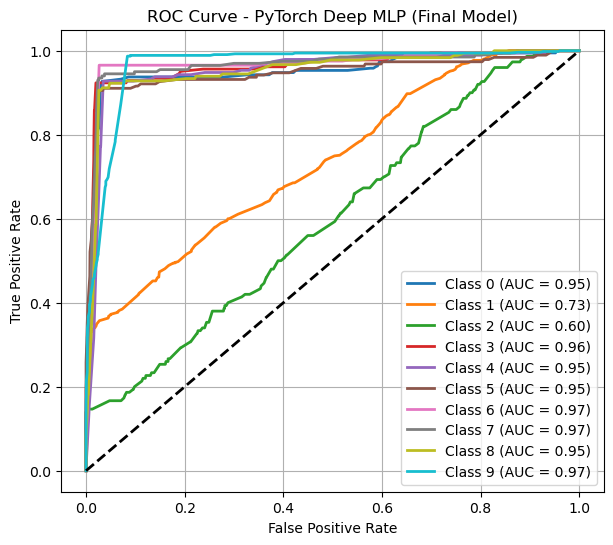

In [14]:
plot_multiclass_roc(
    model=deep_mlp_model,
    test_loader=test_loader,
    n_classes=num_classes,
    title="ROC Curve - PyTorch Deep MLP (Final Model)"
)


In [15]:
tuning_results = []

learning_rates = [0.01, 0.001]
epochs_list = [15, 25]

for lr in learning_rates:
    for ep in epochs_list:
        model = MLP(input_dim, num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        train_model(
            model,
            train_loader,
            criterion,
            optimizer,
            epochs=ep
        )

        acc, prec, rec, f1, auc_score = evaluate_model(model, test_loader)

        tuning_results.append({
            "Model": "MLP",
            "LearningRate": lr,
            "Epochs": ep,
            "Accuracy": acc,
            "Precision_macro": prec,
            "Recall_macro": rec,
            "F1_macro": f1,
            "AUC": auc_score
        })


Epoch 1/15 - Loss: 160.2306
Epoch 2/15 - Loss: 89.0911
Epoch 3/15 - Loss: 18.0560
Epoch 4/15 - Loss: 1.9556
Epoch 5/15 - Loss: 0.3974
Epoch 6/15 - Loss: 0.1714
Epoch 7/15 - Loss: 0.0875
Epoch 8/15 - Loss: 0.0628
Epoch 9/15 - Loss: 0.0485
Epoch 10/15 - Loss: 0.0361
Epoch 11/15 - Loss: 0.0318
Epoch 12/15 - Loss: 0.0264
Epoch 13/15 - Loss: 0.0217
Epoch 14/15 - Loss: 0.0164
Epoch 15/15 - Loss: 0.0130
Epoch 1/25 - Loss: 161.6385
Epoch 2/25 - Loss: 89.7660
Epoch 3/25 - Loss: 20.0392
Epoch 4/25 - Loss: 2.4398
Epoch 5/25 - Loss: 0.4115
Epoch 6/25 - Loss: 0.1846
Epoch 7/25 - Loss: 0.1083
Epoch 8/25 - Loss: 0.0692
Epoch 9/25 - Loss: 0.0490
Epoch 10/25 - Loss: 0.0405
Epoch 11/25 - Loss: 0.0309
Epoch 12/25 - Loss: 0.0253
Epoch 13/25 - Loss: 0.0211
Epoch 14/25 - Loss: 0.0196
Epoch 15/25 - Loss: 0.0144
Epoch 16/25 - Loss: 0.0130
Epoch 17/25 - Loss: 0.0119
Epoch 18/25 - Loss: 0.0095
Epoch 19/25 - Loss: 0.0090
Epoch 20/25 - Loss: 0.0060
Epoch 21/25 - Loss: 0.0069
Epoch 22/25 - Loss: 0.0046
Epoch 23/25

In [16]:
tuning_df = pd.DataFrame(tuning_results)

tuning_df = tuning_df.sort_values(
    by=["F1_macro", "Recall_macro", "Precision_macro", "Accuracy"],
    ascending=False
).reset_index(drop=True)

display(tuning_df)


,Model,LearningRate,Epochs,Accuracy,Precision_macro,Recall_macro,F1_macro,AUC
0,MLP,0.001,25,0.759301,0.782240,0.800618,0.738418,0.912808
1,MLP,0.001,15,0.758557,0.781453,0.799592,0.737510,0.912988
2,MLP,0.010,15,0.746280,0.768573,0.776567,0.727289,0.913461
3,MLP,0.010,25,0.745908,0.767639,0.774551,0.726177,0.910897


In [17]:
final_results = results_df.copy()

# Best Tuned MLP
final_results.loc[len(final_results)] = [
    "Final - PyTorch",
    "MLP (Best Tuned)",
    mlp_results[0],   # Accuracy
    mlp_results[1],   # Precision_macro
    mlp_results[2],   # Recall_macro
    mlp_results[3]    # F1_macro
]

# Deep MLP
final_results.loc[len(final_results)] = [
    "Final - PyTorch",
    "Deep MLP",
    deep_mlp_results[0],  # Accuracy
    deep_mlp_results[1],  # Precision_macro
    deep_mlp_results[2],  # Recall_macro
    deep_mlp_results[3]   # F1_macro
]

# Akademik sıralama
final_results = final_results.sort_values(
    by=["F1_macro", "Recall_macro", "Precision_macro", "Accuracy"],
    ascending=False
).reset_index(drop=True)

display(final_results)


,Stage,Model,Accuracy,Precision_macro,Recall_macro,F1_macro
0,Final - PyTorch,MLP,0.759673,0.782644,0.801145,0.738879
1,Final - PyTorch,MLP (Best Tuned),0.759673,0.782644,0.801145,0.738879
2,Final - PyTorch,Deep MLP,0.745164,0.771409,0.788007,0.717628
3,Final - PyTorch,Deep MLP,0.745164,0.771409,0.788007,0.717628
4,Original Features,RandomForest,0.735491,0.763789,0.777355,0.695510
5,Original Features,LogisticRegression,0.734747,0.663349,0.776536,0.693761
6,"After Feature Selection (RFE, 40 features)",LogisticRegression,0.734747,0.663349,0.776536,0.693761
7,"After Feature Selection (RFE, 40 features)",RandomForest,0.734747,0.663349,0.776536,0.693761
8,"After Dimension Reduction (TruncatedSVD, n=20)",LogisticRegression,0.734747,0.663349,0.776536,0.693761
9,"After Dimension Reduction (TruncatedSVD, n=20)",RandomForest,0.683408,0.644714,0.693657,0.658588


In [18]:
# =========================================
# Final Model Selection (AKADEMİK)
# =========================================

best_model = final_results.sort_values(
    by=["F1_macro", "Recall_macro", "Precision_macro", "Accuracy"],
    ascending=False
).iloc[0]

print("\n================ BEST MODEL SELECTION ================\n")

print(f"Stage              : {best_model['Stage']}")
print(f"Model              : {best_model['Model']}")
print("-" * 55)
print(f"Accuracy            : {best_model['Accuracy']:.4f}")
print(f"Precision (macro)   : {best_model['Precision_macro']:.4f}")
print(f"Recall (macro)      : {best_model['Recall_macro']:.4f}")
print(f"F1-score (macro)    : {best_model['F1_macro']:.4f}")

print("\nSelection Criterion:")
print(
    "The best model was selected based on macro-averaged F1-score, "
    "with recall, precision, and accuracy used as secondary tie-breaking metrics."
)



================ BEST MODEL SELECTION ================

Stage              : Final - PyTorch
Model              : MLP
-------------------------------------------------------
Accuracy            : 0.7597
Precision (macro)   : 0.7826
Recall (macro)      : 0.8011
F1-score (macro)    : 0.7389

Selection Criterion:
The best model was selected based on macro-averaged F1-score, with recall, precision, and accuracy used as secondary tie-breaking metrics.


In [20]:
analysis_notes = [
    "Seçilen modelde macro-averaged precision ve recall değerlerinin yüksek olmasına rağmen "
    "F1-score’un görece daha düşük olması, sınıflar arası performans farklılıklarından "
    "kaynaklanmaktadır. Macro averaging yaklaşımı, tüm sınıfları eşit ağırlıkta "
    "değerlendirdiği için bu durum, modelin genel performansının daha adil ve gerçekçi "
    "biçimde ölçüldüğünü göstermektedir."
]

for note in analysis_notes:
    print(note)


Seçilen modelde macro-averaged precision ve recall değerlerinin yüksek olmasına rağmen F1-score’un görece daha düşük olması, sınıflar arası performans farklılıklarından kaynaklanmaktadır. Macro averaging yaklaşımı, tüm sınıfları eşit ağırlıkta değerlendirdiği için bu durum, modelin genel performansının daha adil ve gerçekçi biçimde ölçüldüğünü göstermektedir.
